## RuCode-CarClassification 2022

Здесь представлен один из вариантов базового решения для конкурса RuCode-2022 в задаче классификации автомобилей на изображении по их цвету.

Для решения этой задачи была использована конволюционная нейронная сеть. В ходе соревнования особую эффективность показало применение функции активации PrReLu.








## Объявление библиотек и загрузка данных

In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/car_color_dataset.zip')

Mounted at /content/car_color_dataset.zip


In [4]:
!unzip "/content/car_color_dataset.zip/MyDrive/car_color_dataset.zip" -d car_color_dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: car_color_dataset/public_test/364.jpg  
  inflating: car_color_dataset/public_test/365.jpg  
  inflating: car_color_dataset/public_test/366.jpg  
  inflating: car_color_dataset/public_test/367.jpg  
  inflating: car_color_dataset/public_test/370.jpg  
  inflating: car_color_dataset/public_test/371.jpg  
  inflating: car_color_dataset/public_test/372.jpg  
  inflating: car_color_dataset/public_test/373.jpg  
  inflating: car_color_dataset/public_test/375.jpg  
  inflating: car_color_dataset/public_test/377.jpg  
  inflating: car_color_dataset/public_test/378.jpg  
  inflating: car_color_dataset/public_test/379.jpg  
  inflating: car_color_dataset/public_test/380.jpg  
  inflating: car_color_dataset/public_test/381.jpg  
  inflating: car_color_dataset/public_test/382.jpg  
  inflating: car_color_dataset/public_test/384.jpg  
  inflating: car_color_dataset/public_test/385.jpg  
  inflating: car_color_dataset/

Посмотрим какие цвета есть у машин (всего 11 цветов)

In [5]:
import os
print(os.listdir("/content/car_color_dataset/train"))

['Blue', 'White', 'Brown', 'Orange', 'Cyan', 'Red', 'Grey', 'Violet', 'Black', 'Yellow', 'Green']


## Предобработка данных

Разделение данных на обучающую и валидационную части

In [6]:
import shutil
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['Black', 'Blue', 'Brown', 'Cyan', 'Green', 'Grey', 'Orange', 'Red', 'Violet', 'White', 'Yellow']

data_root = '/content/car_color_dataset'

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name)
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 440/440 [00:00<00:00, 5999.17it/s]


Аугментации данных

In [7]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=(0, 45)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #AddGaussianNoise(0.,0.3)
])

val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


'Grey'

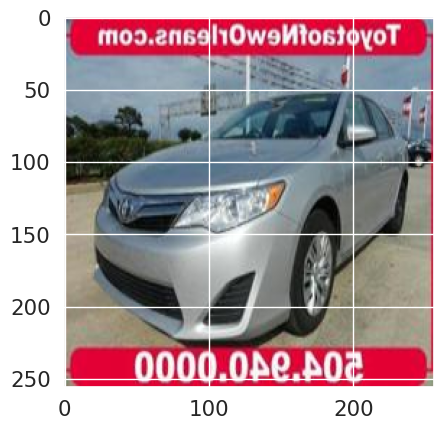

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);
class_names[y_batch[0]]

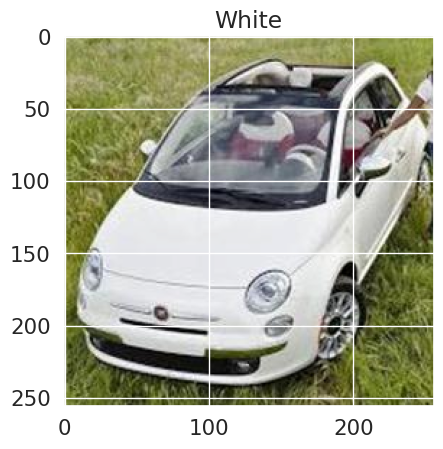

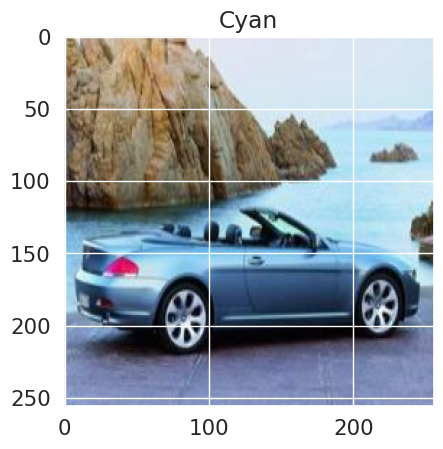

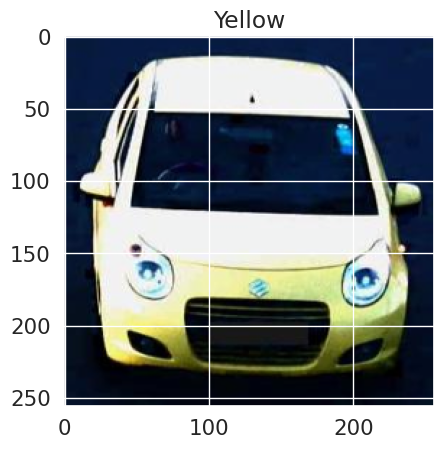

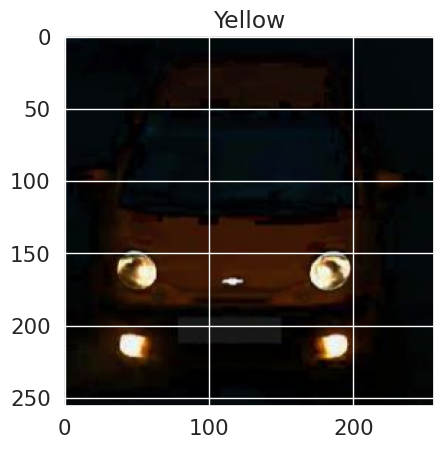

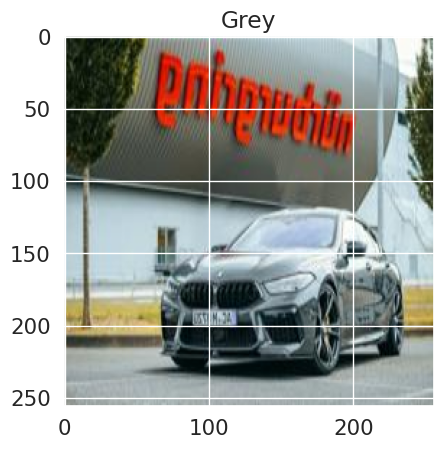

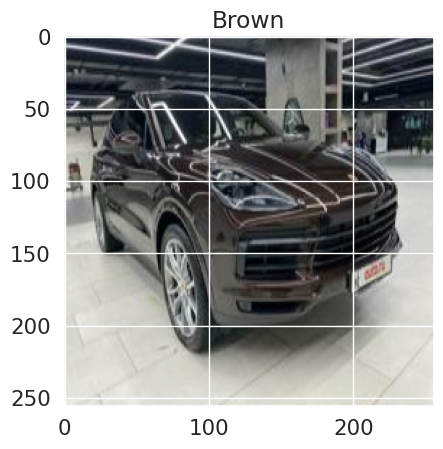

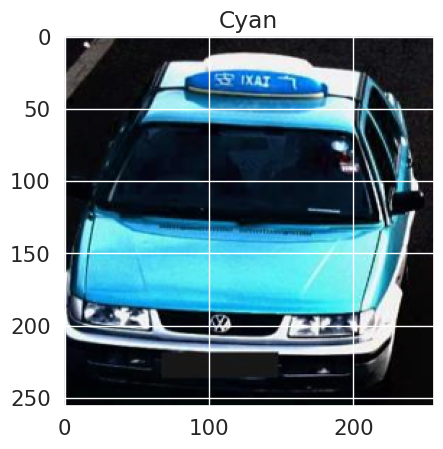

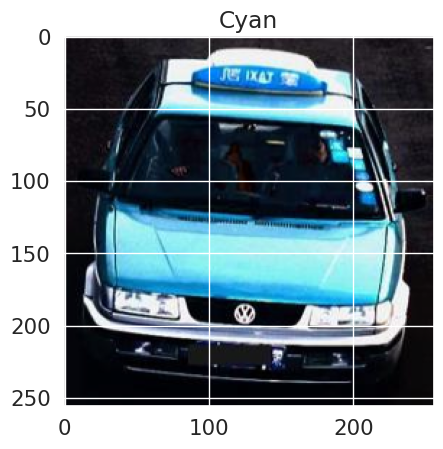

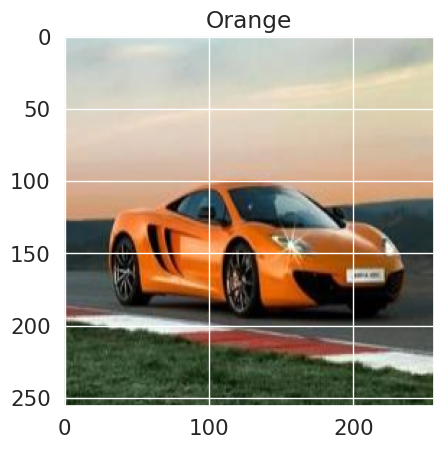

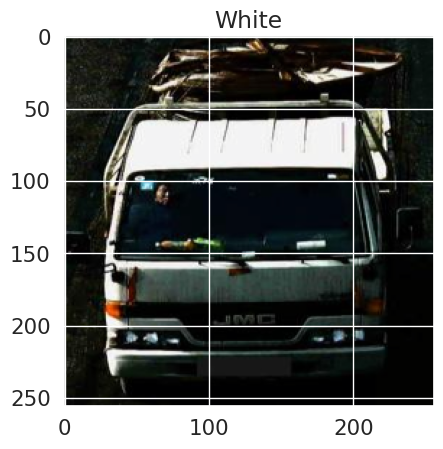

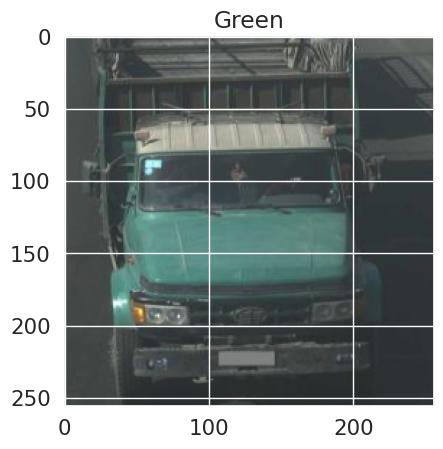

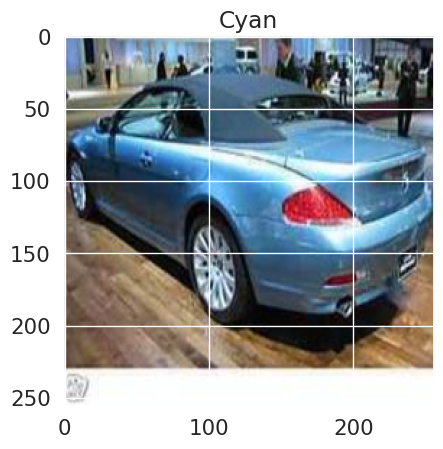

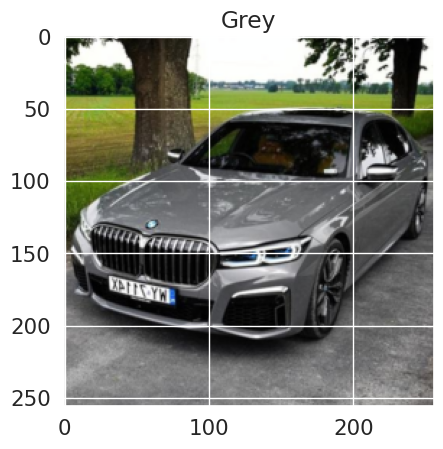

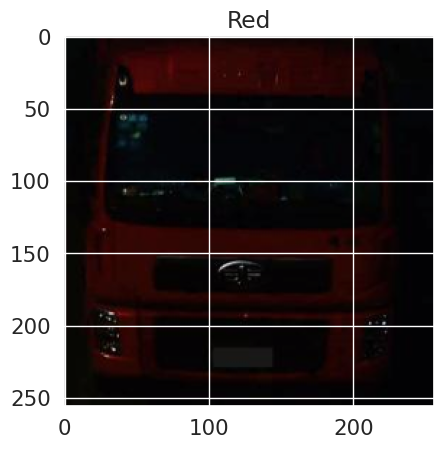

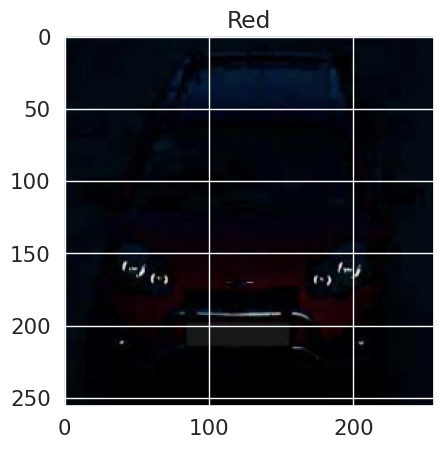

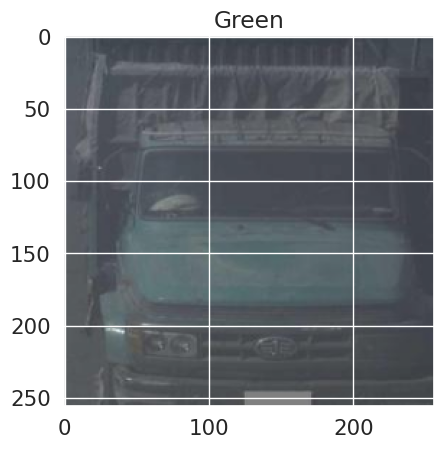

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

## Модель нейронной сети

In [11]:
# модификация старой модели
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.activation1 = nn.PReLU()
        self.activation2 = nn.PReLU()
        self.activation3 = nn.PReLU()
        self.activation4 = nn.PReLU()
        self.activation5 = nn.PReLU()
        self.activation6 = nn.PReLU()
        self.activation7 = nn.PReLU()
        self.activation8 = nn.PReLU()
        self.activation9 = nn.PReLU()
        self.activation10 = nn.PReLU()
        self.activation11 = nn.PReLU()
        self.activation12 = nn.PReLU()
        self.activation13 = nn.PReLU()
        self.activation14 = nn.PReLU()
        self.activation15 = nn.PReLU()
        self.activation16 = nn.PReLU()
        self.activation17 = nn.PReLU()
        self.activation18 = nn.PReLU()
        self.activation19 = nn.PReLU()
        self.activation20 = nn.PReLU()
        self.activation21 = nn.PReLU()

        self.conv1 = nn.Conv2d(3, 6, 5)

        self.cr1 = nn.Conv2d(6, 6, 1)
        self.cr2 = nn.Conv2d(6, 6, 1)

        self.cr3 = nn.Conv2d(6, 6, 1)
        self.cr4 = nn.Conv2d(6, 6, 1)


        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(6, 9, 5)

        self.cr5 = nn.Conv2d(9, 9, 1)
        self.cr6 = nn.Conv2d(9, 9, 1)

        self.cr7 = nn.Conv2d(9, 9, 1)
        self.cr8 = nn.Conv2d(9, 9, 1)


        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(9, 12, 5)

        self.cr9 = nn.Conv2d(12, 12, 1)
        self.cr10 = nn.Conv2d(12, 12, 1)

        self.cr11 = nn.Conv2d(12, 12, 1)
        self.cr12 = nn.Conv2d(12, 12, 1)


        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(12, 15, 5)

        self.cr13 = nn.Conv2d(15, 15, 1)
        self.cr14 = nn.Conv2d(15, 15, 1)

        self.cr15 = nn.Conv2d(15, 15, 1)
        self.cr16 = nn.Conv2d(15, 15, 1)


        self.pool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(15, 18, 5)

        self.cr17 = nn.Conv2d(18, 18, 1)
        self.cr18 = nn.Conv2d(18, 18, 1)

        self.cr19 = nn.Conv2d(18, 18, 1)
        self.cr20 = nn.Conv2d(18, 18, 1)


        self.pool5 = nn.MaxPool2d(2)

        self.flatten = nn.Flatten(start_dim=0,end_dim=2)

        self.fc1 = nn.Linear(18 * 4 * 4, 120)

        self.fc2 = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 120)

        self.fc4 = nn.Linear(120, 120)
        self.fc5 = nn.Linear(120, 120)

        self.fc6 = nn.Linear(120, 84)

        self.fc7 = nn.Linear(84, 84)
        self.fc8 = nn.Linear(84, 84)

        self.fc9 = nn.Linear(84, 84)
        self.fc10 = nn.Linear(84, 84)

        self.fc11 = nn.Linear(84, 11)

    def forward(self, x):

        x = self.conv1(x)
        x = self.activation1(x)

        #y = x.clone()
        #x = self.cr1(x)
        #x = self.activation(x)
        #x = self.cr2(x)
        #x = x + y
        #x = self.activation(x)

        y = x.clone()
        x = self.cr3(x)
        x = self.activation2(x)
        x = self.cr4(x)
        x = x + y

        x = self.activation3(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activation4(x)

        #y = x.clone()
        #x = self.cr5(x)
        #x = self.activation(x)
        #x = self.cr6(x)
        #x = x + y
        #x = self.activation(x)

        y = x.clone()
        x = self.cr7(x)
        x = self.activation5(x)
        x = self.cr8(x)
        x = x + y

        x = self.activation6(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.activation7(x)

        #y = x.clone()
        #x = self.cr9(x)
        #x = self.activation(x)
        #x = self.cr10(x)
        #x = x + y
        #x = self.activation(x)

        y = x.clone()
        x = self.cr11(x)
        x = self.activation8(x)
        x = self.cr12(x)
        x = x + y

        x = self.activation9(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.activation10(x)

        #y = x.clone()
        #x = self.cr13(x)
        #x = self.activation(x)
        #x = self.cr14(x)
        #x = x + y
        #x = self.activation(x)

        y = x.clone()
        x = self.cr15(x)
        x = self.activation11(x)
        x = self.cr16(x)
        x = x + y

        x = self.activation12(x)
        x = self.pool4(x)

        x = self.conv5(x)
        x = self.activation13(x)

        #y = x.clone()
        #x = self.cr17(x)
        #x = self.activation(x)
        #x = self.cr18(x)
        #x = x + y
        #x = self.activation(x)

        y = x.clone()
        x = self.cr19(x)
        x = self.activation14(x)
        x = self.cr20(x)
        x = x + y

        x = self.activation15(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.activation16(x)

        #y = x.clone()
        #x = self.fc2(x)
        #x = self.activation(x)
        #x = self.fc3(x)
        #x = x+y
        #x = self.activation(x)

        y = x.clone()
        x = self.fc4(x)
        x = self.activation17(x)
        x = self.fc5(x)
        x = x+y
        x = self.activation18(x)

        x = self.fc6(x)
        x = self.activation19(x)

        #y = x.clone()
        #x = self.fc7(x)
        #x = self.activation(x)
        #x = self.fc8(x)
        #x = x+y
        #x = self.activation(x)


        y = x.clone()
        x = self.fc9(x)
        x = self.activation20(x)
        x = self.fc10(x)
        x = x+y
        x = self.activation21(x)


        x = self.fc11(x)


        #print(x.shape)
        return x

## Инициализация модели и функций обучения

In [18]:
model = LeNet()

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

# model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:
valscore = [0]
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    model.requires_grad_(True)
                    preds = torch.stack([model(inputs[i]) for i in range(len(inputs))])
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                    model.requires_grad_(False)

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
              valscore.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

## Обучение модели

In [20]:
train_model(model, loss, optimizer, scheduler, num_epochs=21);

Epoch 0/20:


  0%|          | 0/198 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 198/198 [03:03<00:00,  1.08it/s]

train Loss: 1.5326 Acc: 0.4245



100%|██████████| 40/40 [00:16<00:00,  2.39it/s]

val Loss: 1.1678 Acc: 0.6112
Epoch 1/20:



100%|██████████| 198/198 [03:02<00:00,  1.09it/s]

train Loss: 0.9518 Acc: 0.6765



100%|██████████| 40/40 [00:13<00:00,  2.88it/s]

val Loss: 0.7961 Acc: 0.7299
Epoch 2/20:



100%|██████████| 198/198 [03:02<00:00,  1.08it/s]

train Loss: 0.6530 Acc: 0.7858



100%|██████████| 40/40 [00:19<00:00,  2.03it/s]

val Loss: 0.5951 Acc: 0.8040
Epoch 3/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.5401 Acc: 0.8213



100%|██████████| 40/40 [00:14<00:00,  2.71it/s]

val Loss: 0.6504 Acc: 0.8092
Epoch 4/20:



100%|██████████| 198/198 [03:03<00:00,  1.08it/s]

train Loss: 0.4472 Acc: 0.8516



100%|██████████| 40/40 [00:14<00:00,  2.84it/s]

val Loss: 0.5908 Acc: 0.8083
Epoch 5/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.4397 Acc: 0.8575



100%|██████████| 40/40 [00:13<00:00,  2.89it/s]

val Loss: 0.5718 Acc: 0.8295
Epoch 6/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.3752 Acc: 0.8767



100%|██████████| 40/40 [00:13<00:00,  2.89it/s]

val Loss: 0.4760 Acc: 0.8605
Epoch 7/20:



100%|██████████| 198/198 [03:00<00:00,  1.10it/s]

train Loss: 0.2340 Acc: 0.9198



100%|██████████| 40/40 [00:15<00:00,  2.61it/s]

val Loss: 0.3292 Acc: 0.8888
Epoch 8/20:



100%|██████████| 198/198 [03:04<00:00,  1.07it/s]

train Loss: 0.2001 Acc: 0.9331



100%|██████████| 40/40 [00:13<00:00,  2.89it/s]

val Loss: 0.3319 Acc: 0.8951
Epoch 9/20:



100%|██████████| 198/198 [03:02<00:00,  1.09it/s]

train Loss: 0.1819 Acc: 0.9391



100%|██████████| 40/40 [00:13<00:00,  2.87it/s]

val Loss: 0.3202 Acc: 0.8982
Epoch 10/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.1776 Acc: 0.9366



100%|██████████| 40/40 [00:13<00:00,  2.86it/s]

val Loss: 0.3316 Acc: 0.9029
Epoch 11/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.1686 Acc: 0.9394



100%|██████████| 40/40 [00:14<00:00,  2.79it/s]

val Loss: 0.3221 Acc: 0.9013
Epoch 12/20:



100%|██████████| 198/198 [03:05<00:00,  1.07it/s]

train Loss: 0.1583 Acc: 0.9468



100%|██████████| 40/40 [00:14<00:00,  2.71it/s]

val Loss: 0.3179 Acc: 0.9045
Epoch 13/20:



100%|██████████| 198/198 [03:04<00:00,  1.07it/s]

train Loss: 0.1552 Acc: 0.9454



100%|██████████| 40/40 [00:13<00:00,  2.87it/s]

val Loss: 0.3357 Acc: 0.9092
Epoch 14/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.1351 Acc: 0.9507



100%|██████████| 40/40 [00:13<00:00,  2.91it/s]

val Loss: 0.3240 Acc: 0.9060
Epoch 15/20:



100%|██████████| 198/198 [03:00<00:00,  1.09it/s]

train Loss: 0.1303 Acc: 0.9516



100%|██████████| 40/40 [00:17<00:00,  2.33it/s]

val Loss: 0.3215 Acc: 0.9060
Epoch 16/20:



100%|██████████| 198/198 [02:59<00:00,  1.10it/s]

train Loss: 0.1319 Acc: 0.9514



100%|██████████| 40/40 [00:13<00:00,  2.92it/s]

val Loss: 0.3209 Acc: 0.9076
Epoch 17/20:



100%|██████████| 198/198 [03:03<00:00,  1.08it/s]

train Loss: 0.1296 Acc: 0.9549



100%|██████████| 40/40 [00:14<00:00,  2.80it/s]

val Loss: 0.3235 Acc: 0.9076
Epoch 18/20:



100%|██████████| 198/198 [03:05<00:00,  1.07it/s]

train Loss: 0.1285 Acc: 0.9545



100%|██████████| 40/40 [00:13<00:00,  2.92it/s]

val Loss: 0.3227 Acc: 0.9060
Epoch 19/20:



100%|██████████| 198/198 [02:59<00:00,  1.10it/s]

train Loss: 0.1276 Acc: 0.9537



100%|██████████| 40/40 [00:15<00:00,  2.66it/s]

val Loss: 0.3245 Acc: 0.9076
Epoch 20/20:



100%|██████████| 198/198 [03:01<00:00,  1.09it/s]

train Loss: 0.1270 Acc: 0.9545



100%|██████████| 40/40 [00:17<00:00,  2.34it/s]

val Loss: 0.3241 Acc: 0.9107


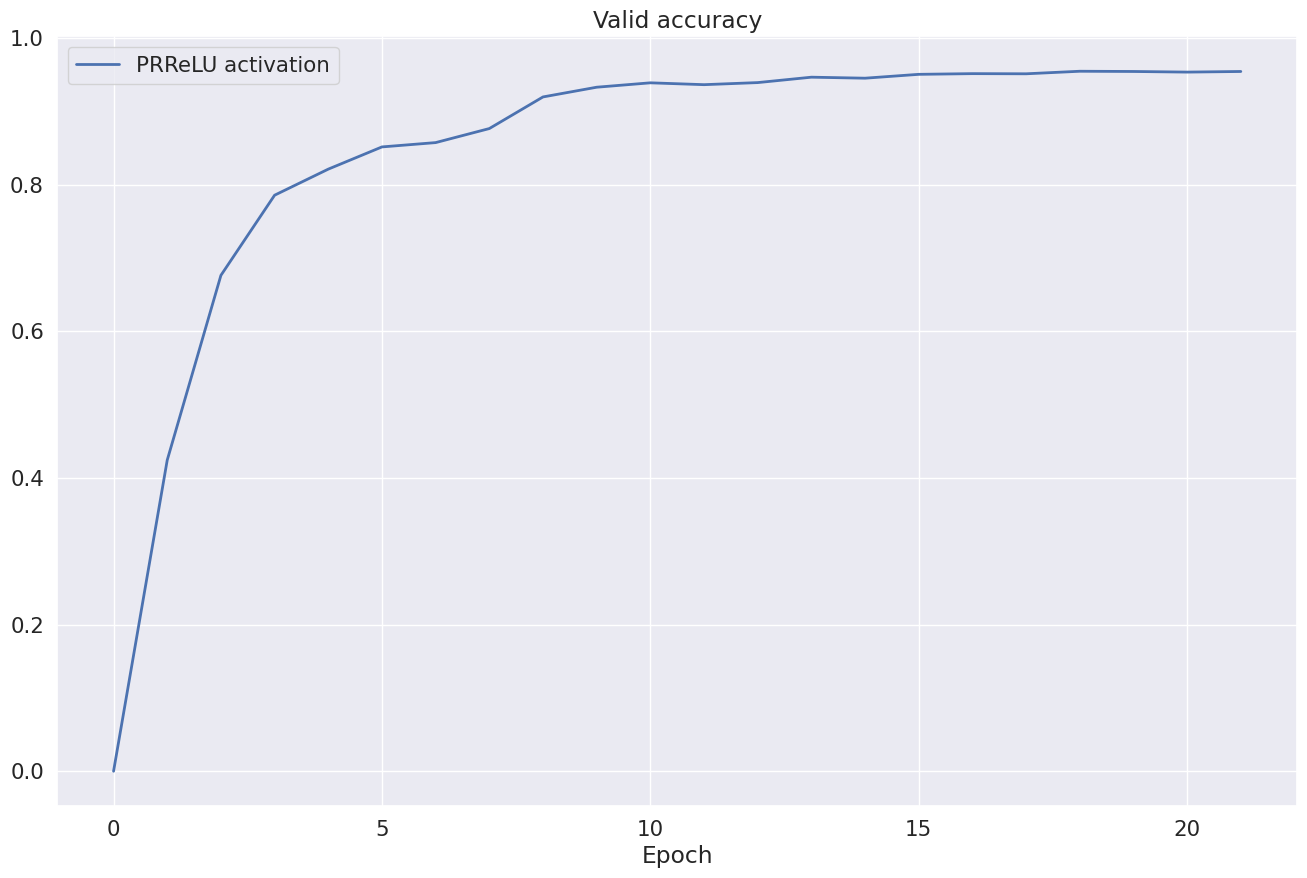

In [21]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(len(valscore)), valscore, label="PRReLU activation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.show()

In [22]:
valscore[-1]

tensor(0.9545)

## Прогноз модели на тестовой выборке

Загрузка тестовых данных

In [23]:
drive.mount('/content/private_dataset.zip')

Mounted at /content/private_dataset.zip


In [24]:
!unzip "/content/private_dataset.zip/MyDrive/private_dataset.zip" -d privatetest2

Archive:  /content/private_dataset.zip/MyDrive/private_dataset.zip
   creating: privatetest2/private_dataset/
  inflating: privatetest2/private_dataset/0.jpg  
  inflating: privatetest2/private_dataset/2.jpg  
  inflating: privatetest2/private_dataset/3.jpg  
  inflating: privatetest2/private_dataset/4.jpg  
  inflating: privatetest2/private_dataset/6.jpg  
  inflating: privatetest2/private_dataset/8.jpg  
  inflating: privatetest2/private_dataset/9.jpg  
  inflating: privatetest2/private_dataset/10.jpg  
  inflating: privatetest2/private_dataset/13.jpg  
  inflating: privatetest2/private_dataset/14.jpg  
  inflating: privatetest2/private_dataset/18.jpg  
  inflating: privatetest2/private_dataset/19.jpg  
  inflating: privatetest2/private_dataset/20.jpg  
  inflating: privatetest2/private_dataset/21.jpg  
  inflating: privatetest2/private_dataset/23.jpg  
  inflating: privatetest2/private_dataset/24.jpg  
  inflating: privatetest2/private_dataset/27.jpg  
  inflating: privatetest2/priv

In [25]:
test_dir = '/content/privatetest2/private_dataset'
shutil.copytree(os.path.join(data_root, '/content/privatetest2/private_dataset'), os.path.join(test_dir, 'unknown'))

'/content/privatetest2/private_dataset/unknown'

In [26]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path.replace('/content/privatetest2/private_dataset/unknown/', '').replace('.jpg', ''),))
        return tuple_with_path

test_dataset = ImageFolderWithPaths('/content/privatetest2/private_dataset', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

Применение модели к тестовым данным

In [27]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = torch.stack([model(inputs[i]) for i in range(len(inputs))])
    preds = preds.argmax(-1)
    predictions = [class_names[preds[i]] for i in range(len(preds))]
    test_predictions.append(
        predictions
        # torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
        )
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 90/90 [00:28<00:00,  3.16it/s]


In [28]:
len(test_predictions)

1434

Посмотрим результат работы модели

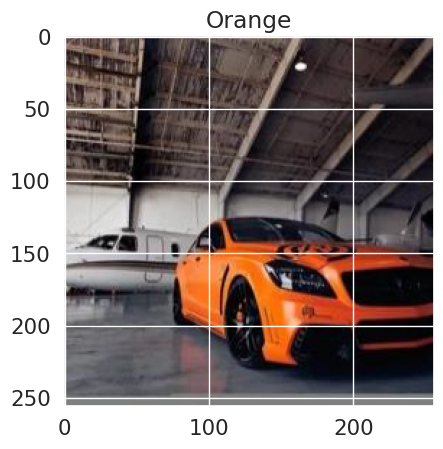

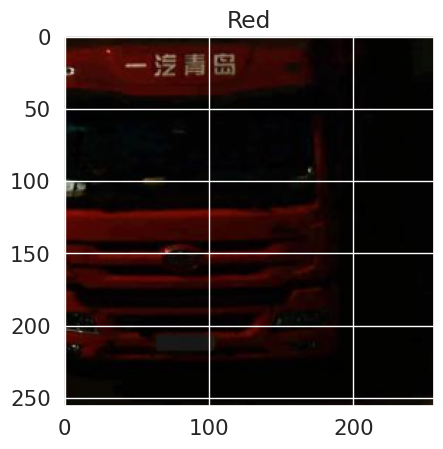

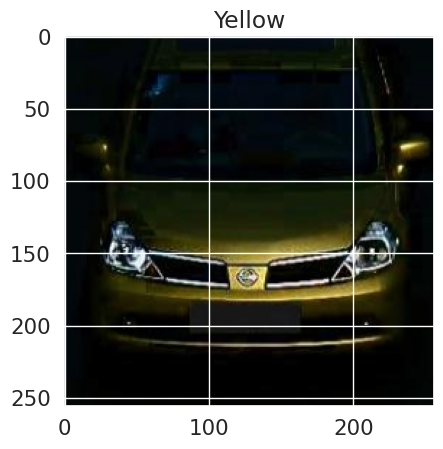

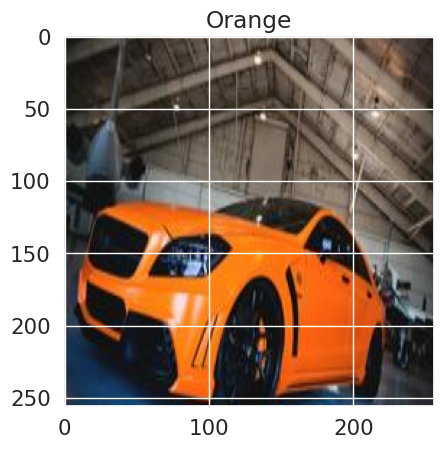

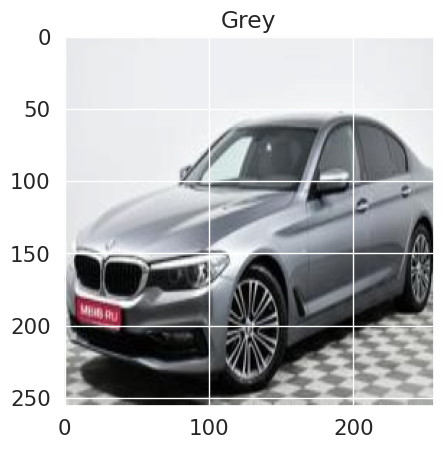

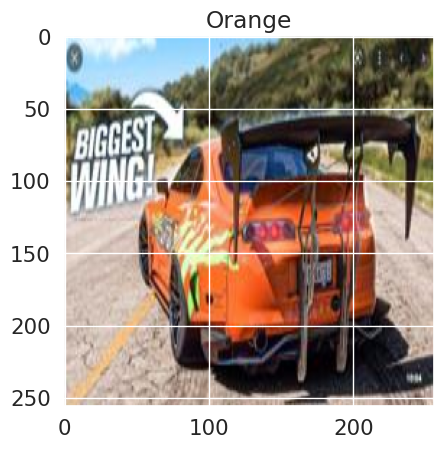

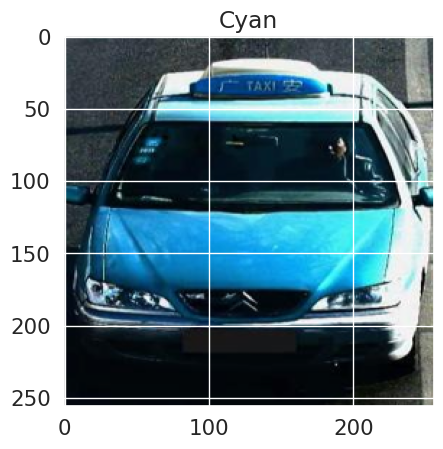

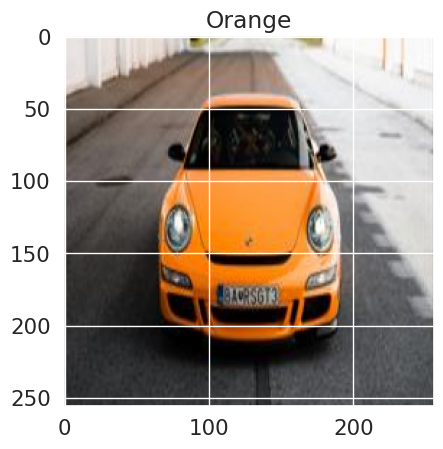

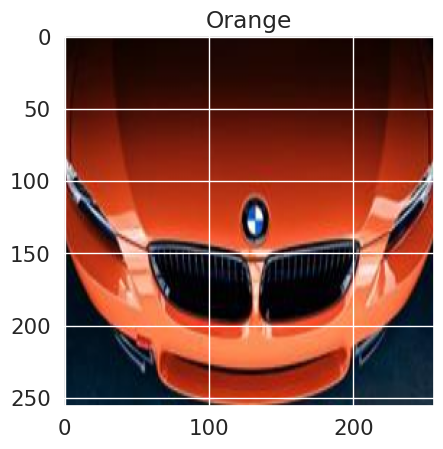

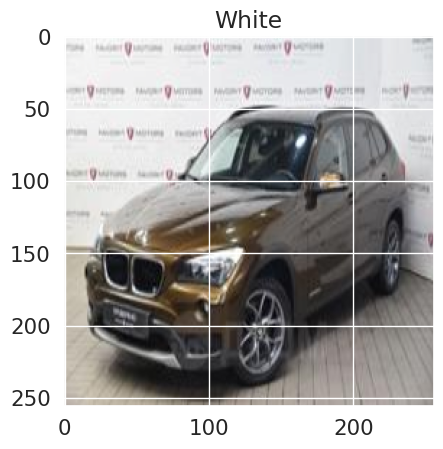

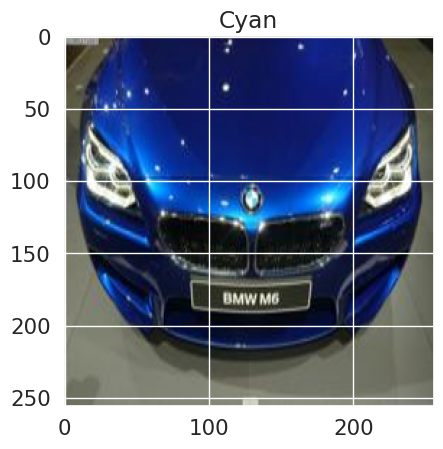

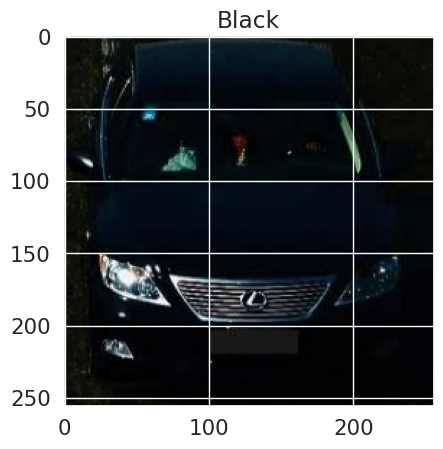

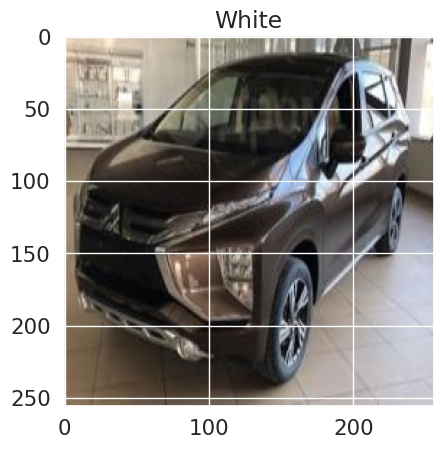

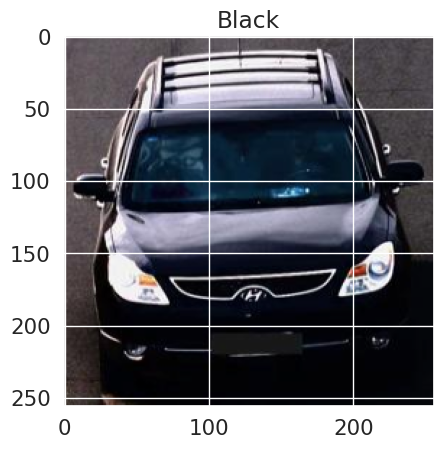

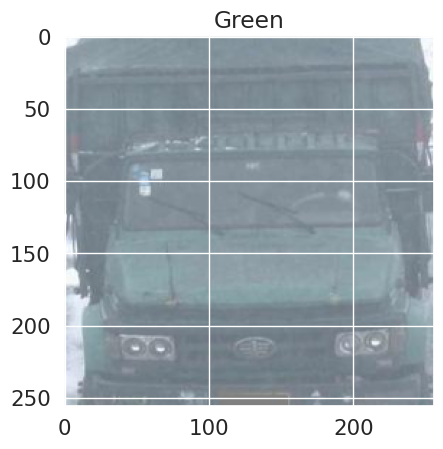

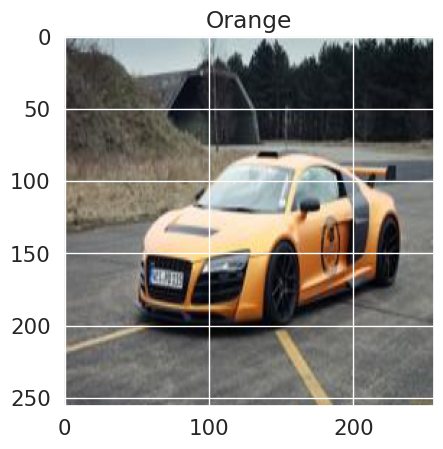

In [29]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

## Запись полученных результатов работы модели в submission-файл для отправки на контест

In [30]:
submission_df = pd.DataFrame.from_dict({'IDs':[ int(item) for item  in test_img_paths], 'label': test_predictions})

In [31]:
submission_df

IDs   label
0        0  Orange
1        1     Red
2       10  Yellow
3      100  Orange
4     1000    Grey
...    ...     ...
1429   995  Violet
1430   996   White
1431   997  Orange
1432   998     Red
1433   999    Cyan

[1434 rows x 2 columns]

Т. к. для контеста данные нужно упорядочить по Id и оставить только цвета, преобразуем submission

In [32]:
submission_df.sort_values('IDs')

IDs   label
0       0  Orange
1       1     Red
546     2   Black
657     3   Brown
768     4   White
..    ...     ...
479  1429  Violet
481  1430   Black
482  1431   Brown
483  1432     Red
484  1433   Black

[1434 rows x 2 columns]

In [33]:
submission_df.sort_values('IDs')['label']

0      Orange
1         Red
546     Black
657     Brown
768     White
        ...  
479    Violet
481     Black
482     Brown
483       Red
484     Black
Name: label, Length: 1434, dtype: object

In [34]:
sub_df = submission_df.sort_values('IDs')['label']

In [35]:
sub_df

0      Orange
1         Red
546     Black
657     Brown
768     White
        ...  
479    Violet
481     Black
482     Brown
483       Red
484     Black
Name: label, Length: 1434, dtype: object

In [36]:
sub_df.to_csv('submission.csv', index= False, header=False)

In [37]:
pd.read_csv('submission.csv')

Orange
0        Red
1      Black
2      Brown
3      White
4     Yellow
...      ...
1428  Violet
1429   Black
1430   Brown
1431     Red
1432   Black

[1433 rows x 1 columns]